## Imports

In [1]:
#pandas/numpy
import pandas as pd
import numpy as np

#loading data
import bz2
import json

#plotting
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import wordcloud
from PIL import Image
import plotly.express as px
import chart_studio.plotly as py
import plotly.graph_objs as go

#math operations
import math

#statistics
from scipy import stats
#from sklearn.preprocessing import MultiLabelBinarizer
import statsmodels.api as sm
import statsmodels.formula.api as smf

#matching algorithm
import networkx as nx

#util functions 
from utils import gmean_occupations, visualize_by_occupation, quotes_by_gender, unique_speaker_per_gender, get_champlex

#count in collection
from collections import Counter

#warnings
import warnings
#ignore future warnings
#warnings.filterwarnings('ignore')

## Dataset


In [2]:
DATA_FOLDER = 'data/'
QUOTES_DATA = DATA_FOLDER + 'data_observational.json.bz2'

## Dictionnaries

In [3]:
DICTIONNARY_FOLDER = DATA_FOLDER + 'dictionnaries/'
DICT_OCCUPATIONS = DICTIONNARY_FOLDER + 'occupations_categories.json'
DICT_DEGREES = DICTIONNARY_FOLDER + 'degrees_categories.json'

## Load the data

In [4]:
quotes = pd.read_json(QUOTES_DATA)

In [5]:
with open(DICT_OCCUPATIONS) as f:
    dict_occupations = json.load(f)

In [6]:
with open(DICT_DEGREES) as f:
    dict_degrees = json.load(f)

# 1. Some preprocessing again

In [7]:
def translate(my_list, my_dict):
    """Allows to transform a list of items into a list of corresponding categories. 
    The list returned contains uniques category (the duplicates are removed).
    
    Parameters
    ----------
    my_list: the list to be translated
    my_dict: the dictionnary according which we want to translate the list
    
    Returns
    --------
    list of uniques categories"""
    translated_list = []
    for i in my_list:
        if i in my_dict.keys():
            translated_list.append(my_dict[i])
        else:
            translated_list.append('Others')
    #Drop duplicates
    return (list(set(translated_list)))
    
        

Now, we replace the occupations and academic degrees by more general categories

In [8]:
quotes['occupation'] = quotes['occupation'].apply(lambda x: translate(x, dict_occupations))

In [9]:
quotes['academic_degree'] = quotes['academic_degree'].apply(lambda x: translate(x, dict_degrees))

Prepare the dataset for propensity scores calculations:

In [10]:
print('Our dataset contains', quotes.shape[0], 'quotes from female speakers.')

Our dataset contains 1761820 quotes from female speakers.


Now, we want to calculate the propensity scores of each speaker. To do that, we need to group the quotations by speakers, and to recover some information about them.

In [11]:
grouped_speakers = quotes.groupby(['qids', 'label'])

After having grouped the quotations per speaker, we take the attributes corresponding to the first quotation: these attributes are immutable (the academic degree, the occupation, the speaker name and the gender), thus we can recover it from the first quotation.

In [12]:
attributes_immutable = grouped_speakers.first().reset_index().drop(['year', 
                                                                   'quotation', 'numOccurrences', 'age'], axis = 1)
attributes_immutable

,qids,label,speaker,gender,occupation,academic_degree
0,Q1000727,0,Ruslan Galitsky,male,[Military & Order],[candidate]
1,Q100230,0,Ludger Kühnhardt,male,[Teaching & Education],[doctor]
2,Q100308,1,Joachim Weimann,male,"[Literature, Teaching & Education, Social Scie...",[doctor]
3,Q1006191,1,F. Földényi,male,"[Service, Media & Journalism, Teaching & Educa...",[Others]
4,Q100749,0,Clemens Fuest,male,"[Teaching & Education, Social Sciences & Ethno...",[doctor]
...,...,...,...,...,...,...
9343,Q996967,1,Diane Coyle,female,"[Media & Journalism, Teaching & Education, Soc...",[doctor]
9344,Q99818,0,Holger Afflerbach,male,"[Teaching & Education, Historian, Literature]",[doctor]
9345,Q99860,0,Ottmar Edenhofer,male,"[Teaching & Education, Social Sciences & Ethno...","[doctor, bachelor]"
9346,Q99860,1,Ottmar Edenhofer,male,"[Teaching & Education, Social Sciences & Ethno...","[doctor, bachelor]"


Now we will calculate the number of quotes per speaker, as well as the number of occurrences per speaker. We also put the age of the speaker to the median age of all its quotations. 

In [13]:
#Get the number of unique quotes per speaker
quotations_per_speaker = grouped_speakers['quotation'].count().reset_index(name='nb_quotes')

#Get the number of total occurrences of the speaker
occurrences_per_speaker = grouped_speakers['numOccurrences'].sum().reset_index(name='nb_occurrences')

#Get the median age of the speaker if she talks many times
age_per_speaker = grouped_speakers['age'].median().reset_index(name='age')

In [14]:
attributes_mutable = pd.merge(pd.merge(quotations_per_speaker, occurrences_per_speaker, on = ['qids', 'label']), 
                              age_per_speaker, on = ['qids', 'label'])
attributes_mutable.head()

,qids,label,nb_quotes,nb_occurrences,age
0,Q1000727,0,1,2,44.0
1,Q100230,0,1,1,59.0
2,Q100308,1,1,1,63.0
3,Q1006191,1,1,1,67.0
4,Q100749,0,300,1654,48.0


In [15]:
data_per_speaker = pd.merge(attributes_immutable, attributes_mutable, on = ['qids', 'label'])

Hot one encoding

In [16]:
dummies_occ = pd.get_dummies(data_per_speaker['occupation'].explode()).sum(level=0)
dummies_degree = pd.get_dummies(data_per_speaker['academic_degree'].explode()).sum(level=0)

/var/folders/ml/pwv1t2ns5tl4nwcjhl4myl8m0000gn/T/ipykernel_2967/3314558053.py:1: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  dummies_occ = pd.get_dummies(data_per_speaker['occupation'].explode()).sum(level=0)
/var/folders/ml/pwv1t2ns5tl4nwcjhl4myl8m0000gn/T/ipykernel_2967/3314558053.py:2: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  dummies_degree = pd.get_dummies(data_per_speaker['academic_degree'].explode()).sum(level=0)


In [17]:
dummies_gender = pd.get_dummies(data_per_speaker['gender'])

In [18]:
##C'est sombre mais get_dummies cree une colomn 'Others' donc en attendant de comprendre pq:
dummies_occ.drop(['Others'], axis = 1, inplace = True)
dummies_degree.drop(['Others'], axis = 1, inplace = True)

In [19]:
#Parce que la regression aime pas les espaces dans les noms de variables, ni les "&"
dummies_occ.columns = dummies_occ.columns.str.replace(" ", "_")
dummies_occ.columns = dummies_occ.columns.str.replace("&", "and")
dummies_degree.columns = dummies_degree.columns.str.replace(" ", "_")

In [20]:
data_features = pd.merge(pd.merge(data_per_speaker, dummies_occ, left_index = True, right_index = True), dummies_degree, left_index = True, right_index = True)
data_features = pd.merge(data_features, dummies_gender, left_index = True, right_index = True)

Before calculating the propensity scores, we should standardize the continuous features. Let's look at their distributions in order to choose an appropriate standardization. 

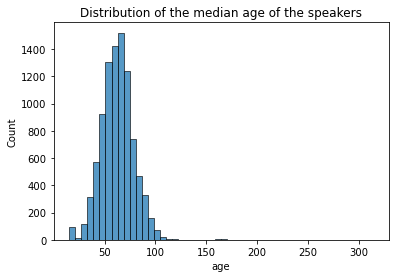

In [21]:
ax = sns.histplot(data_features['age'], bins = 50)
ax.set_title("Distribution of the median age of the speakers");

The distribution of the age seems to follow a gaussian distribution, thus, we will standardize it.

In [22]:
data_features['age'] = (data_features['age'] - data_features['age'].mean())/data_features['age'].std()
data_features.head(2)

,qids,label,speaker,gender,occupation,academic_degree,nb_quotes,nb_occurrences,age,Activist,...,candidate,certificate,doctor,high_school_diploma,master,non_specified_degree,not_classified,professor,female,male
0,Q1000727,0,Ruslan Galitsky,male,[Military & Order],[candidate],1,2,-1.109912,0,...,1,0,0,0,0,0,0,0,0,1
1,Q100230,0,Ludger Kühnhardt,male,[Teaching & Education],[doctor],1,1,-0.198774,0,...,0,0,1,0,0,0,0,0,0,1


Now the dataset is ready for the propensity scores calculation and matching (petit rappel de la théorie ici serait good!)

# 2. Create a balanced dataset to reduce bias

Now the dataset is ready for the observational study: pair identical people, propensity scores calculation and matching (petit rappel de la théorie ici!)

First, we know that some speakers might appear before and after the #MeToo movement. We decide to pair them up, because the goal is to match 2 identical person in terms of their observal covariates, but here, we already know that they are the same person! With just a few years more. But we assume that the difference in age in minor compared to the fact that all other covariates are exaclty the same, and not only the observable ones, since it is the same person!
Thus, we first pair the identical speakers that appear in both groups (control and treated). Then, for the others (i.e, the speakers who speak ONLY before the movement or ONLY after), we will use the method of propensity scores calculation based on the observable covariates = `age`, `occupation`, `academic_degree`.

## Pair up identical speakers

In [23]:
print("Number of speakers speaking both before and after",
      data_features[data_features['qids'].duplicated(keep = 'first') == True].shape[0])

Number of speakers speaking both before and after 3363


In [24]:
data_features.drop(['academic_degree', 'occupation'], axis = 1, inplace = True)

In [25]:
speakers_twice = data_features[data_features['qids'].duplicated(keep = False) == True]

## Pair up non-identical speakers

In [26]:
speakers_once = pd.concat([data_features,speakers_twice])

In [27]:
speakers_once.drop_duplicates(keep = False, inplace = True)

In [28]:
print('Now, we will try to pair up the other speakers, they are:', speakers_once.shape[0])

Now, we will try to pair up the other speakers, they are: 2622


### Propensity scores calculation

In [29]:
occupations_for_regression = ['C('+ str(x)+ ')' for x in dummies_occ.columns.tolist()]

In [30]:
degrees_for_regression = ['C('+ str(x)+ ')' for x in dummies_degree.columns.tolist()]

In [31]:
def create_formula_from_list_categories(my_list):
    list_for_regression = ['C('+ str(x)+ ')' for x in my_list]
    formula = ''
    for i in list_for_regression:
        formula += i
        if i != list_for_regression[-1]:
            formula += ' + '
    return formula
    

In [32]:
formula_occupations = create_formula_from_list_categories(dummies_occ.columns.tolist())

In [33]:
formula_degrees = create_formula_from_list_categories(dummies_degree.columns.tolist())

In [34]:
##TODO : explain the goal of overfitting: why we set the regularization term to 0, 
#as well as why we increase the maxiter term

In [35]:
mod = smf.logit(formula='label ~  age + ' + formula_occupations + ' + ' + formula_degrees + '+ C(female)', data=speakers_once)

#Without regularization term 
res = mod.fit_regularized(maxiter = 10000000000000000, alpha = 0)

# Extract the estimated propensity scores
speakers_once['Propensity_score'] = res.predict()

print(res.summary())

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.6821128477363692
            Iterations: 245
            Function evaluations: 246
            Gradient evaluations: 245
                           Logit Regression Results                           
Dep. Variable:                  label   No. Observations:                 2622
Model:                          Logit   Df Residuals:                     2581
Method:                           MLE   Df Model:                           40
Date:                Sat, 11 Dec 2021   Pseudo R-squ.:                 0.01480
Time:                        13:11:58   Log-Likelihood:                -1788.5
converged:                       True   LL-Null:                       -1815.4
Covariance Type:            nonrobust   LLR p-value:                   0.07196
                                            coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------

In [36]:
speakers_once

,qids,label,speaker,gender,nb_quotes,nb_occurrences,age,Activist,Administrative,Artist,...,certificate,doctor,high_school_diploma,master,non_specified_degree,not_classified,professor,female,male,Propensity_score
0,Q1000727,0,Ruslan Galitsky,male,1,2,-1.109912,0,0,0,...,0,0,0,0,0,0,0,0,1,0.360459
1,Q100230,0,Ludger Kühnhardt,male,1,1,-0.198774,0,0,0,...,0,1,0,0,0,0,0,0,1,0.485618
2,Q100308,1,Joachim Weimann,male,1,1,0.044196,0,0,0,...,0,1,0,0,0,0,0,0,1,0.459340
3,Q1006191,1,F. Földényi,male,1,1,0.287166,0,0,1,...,0,0,0,0,0,0,0,0,1,0.545214
6,Q100836,0,Gerald Hüther,male,1,1,0.104938,0,0,0,...,0,1,0,0,0,0,0,0,1,0.463997
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9337,Q995192,1,Howard Wolpe,male,1,1,0.955333,0,0,0,...,0,1,0,0,0,0,0,0,1,0.509442
9340,Q99590,1,Rebekka Habermas,female,1,1,-0.259517,0,0,0,...,0,1,0,0,0,0,0,1,0,0.528434
9341,Q99634,0,Joachim Milberg,male,1,2,0.590878,0,0,0,...,0,1,0,0,0,0,0,0,1,0.448928
9344,Q99818,0,Holger Afflerbach,male,8,13,-0.320259,0,0,0,...,0,1,0,0,0,0,0,0,1,0.505353


# 3. Do women in general speak more after #MeToo?

## Matching balanced by gender

In [37]:
def get_similarity(propensity_score1, propensity_score2):
    '''Calculate similarity for instances with given propensity scores'''
    return 1-np.abs(propensity_score1-propensity_score2)

In [38]:
speakers_once.head(2)

,qids,label,speaker,gender,nb_quotes,nb_occurrences,age,Activist,Administrative,Artist,...,certificate,doctor,high_school_diploma,master,non_specified_degree,not_classified,professor,female,male,Propensity_score
0,Q1000727,0,Ruslan Galitsky,male,1,2,-1.109912,0,0,0,...,0,0,0,0,0,0,0,0,1,0.360459
1,Q100230,0,Ludger Kühnhardt,male,1,1,-0.198774,0,0,0,...,0,1,0,0,0,0,0,0,1,0.485618


In [39]:
"""# Separate the treatment and control groups
treatment_df = speakers_once[speakers_once['label'] == 1]
control_df = speakers_once[speakers_once['label'] == 0]

# Create an empty undirected graph
G = nx.Graph()

# Loop through all the pairs of instances
for control_id, control_row in control_df.iterrows():
    for treatment_id, treatment_row in treatment_df.iterrows():

        # Calculate the similarity 
        # Adds an edge only if the individuals have the same gender
        if (control_row['gender'] == treatment_row['gender']):
            similarity = get_similarity(control_row['Propensity_score'],
                                    treatment_row['Propensity_score'])

        # Add an edge between the two instances weighted by the similarity between them
            G.add_weighted_edges_from([(control_id, treatment_id, similarity)])

# Generate and return the maximum weight matching on the generated graph
matching = nx.max_weight_matching(G)""";

In [40]:
"""matched = [i[0] for i in list(matching)] + [i[1] for i in list(matching)]
balanced_speakers_once = speakers_once.loc[matched]
balanced_speakers = pd.concat([balanced_speakers_once, speakers_twice])""";

In [41]:
"""##Pour éviter de run again le matching 
balanced_speakers.to_json(DATA_FOLDER + 'results/balanced_dataset_gender.json.bz2')""";

In [42]:
"""#On sauvegarde aussi les valeurs de paires
textfile = open("matching_by_gender.txt", "w")
for element in matching:
    textfile.write(str(element) + "\n")
textfile.close()""";

## Results

We have saved the results of the matching in a separate file, which is called balanced_dataset_by_gender.json.bz2. The file is available here [here](data/results/balanced_dataset_by_gender.csv.bz2). 

In [43]:
DATA_FOLDER_RESULT = 'data/results/'
BALANCED_DATA_BY_GENDER = DATA_FOLDER_RESULT + 'balanced_dataset_by_gender.json.bz2'
#BALANCED_DATA_FEMALE = DATA_FOLDER_RESULT + 'balanced_dataset_female.json.bz2'


In [44]:
balanced_all_genders = pd.read_json(BALANCED_DATA_BY_GENDER)
#balanced_female = pd.read_json(BALANCED_DATA_FEMALE)

Now that we have a balanced dataset, meaning we have pairs of similar speakers of same gender before and after the movement, let's quickly take a look at the size of our data.

In [45]:
pd.crosstab([balanced_all_genders.label], [balanced_all_genders.gender])

gender,female,male
label,,
0,983,3639
1,983,3639


Now, the goal is to compare the speakers' number of quotes and number of occurrences, depending on their gender, before and after #MeToo. Let's first take a look at the distributions of the data.

In [46]:
male_balanced = balanced_all_genders[balanced_all_genders['gender'] == 'male']
fmale_balanced = balanced_all_genders[balanced_all_genders['gender'] == 'female']

male_before_metoo = balanced_all_genders[(balanced_all_genders['label']==0)&(balanced_all_genders['gender'] == 'male')]
#proportion nombre d'occurrences de citations par speaker homme avant me too, par rapport au nombre total d'occurences sur tous les hommes
prop_male_before =  male_before_metoo['nb_occurrences']/(male_balanced['nb_occurrences'].sum())

male_after_metoo = balanced_all_genders[(balanced_all_genders['label']==1)&(balanced_all_genders['gender'] == 'male')]
#proportion nombre d'occurrences de citations par speaker homme après me too, par rapport au nombre total d'occurences sur tous les hommes
prop_male_after=  male_after_metoo['nb_occurrences']/(male_balanced['nb_occurrences'].sum())

fmale_before_metoo = balanced_all_genders[(balanced_all_genders['label']==0)&(balanced_all_genders['gender'] == 'female')]
#proportion nombre d'occurrences de citations par speaker femme avant me too, par rapport au nombre total d'occurences sur tous les hommes
prop_fmale_before =  fmale_before_metoo['nb_occurrences']/(fmale_balanced['nb_occurrences'].sum())

fmale_after_metoo = balanced_all_genders[(balanced_all_genders['label']==1)&(balanced_all_genders['gender'] == 'female')]
#proportion nombre d'occurrences de citations par speaker femme après me too, par rapport au nombre total d'occurences sur tous les hommes
prop_fmale_after=  fmale_after_metoo['nb_occurrences']/(fmale_balanced['nb_occurrences'].sum())

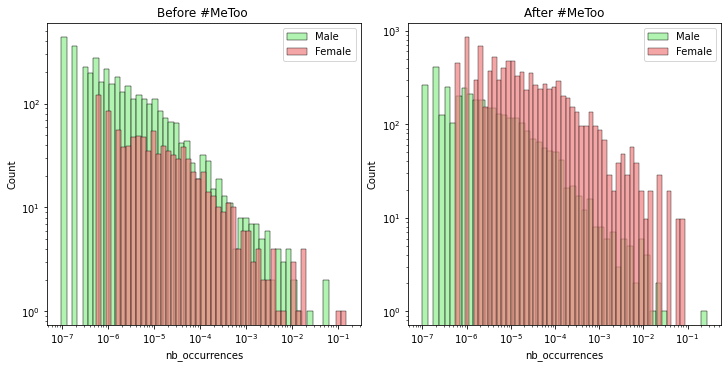

In [47]:
fig, axs = plt.subplots(nrows=1, ncols=2,constrained_layout=True, figsize=(10, 5))
sns.histplot(ax = axs[0], 
                 data = prop_male_before, 
                 bins = 50,
                 log_scale = True,
                 color = 'lightgreen', 
                 alpha = 0.7, 
                 legend = True,
                 stat = 'count')
sns.histplot(ax = axs[0],
                 data = prop_fmale_before, 
                 bins = 50,
                 log_scale = True,
                 color = 'lightcoral', 
                 alpha = 0.7, 
                 legend = True, 
                 stat = 'count')
axs[0].set_title('Before #MeToo ')
axs[0].legend(labels=['Male','Female']);
axs[0].set(yscale = 'log')
sns.histplot(ax = axs[1],
                 data = prop_male_after, 
                 bins = 50,
                 log_scale = True,
                 color = 'lightgreen', 
                 alpha = 0.7, 
                 legend = True, 
                 stat = 'count')
sns.histplot(ax = axs[1],
                 data = prop_fmale_after, 
                 bins = 50,
                 log_scale = True,
                 color = 'lightcoral', 
                 alpha = 0.7, 
                 legend = True, 
                 stat = 'frequency')
axs[1].set_title('After #MeToo')
axs[1].legend(labels=['Male','Female']);
axs[1].set(yscale = 'log')

plt.show()

We observe that the distributions are highly skewed. Thus, we will not use mean neither the standard deviation to compare our distributions. Instead, we will take a look at the median and the geometric means. We will create bootsraped confidence intervals for these estimators.

In [48]:
#LISA: j'ai enlevé la moyenne comme on dit que c'est skewed je pense qu'on peut juste direct dire que la 
#moyenne aura pas de sens + j'ai ajouté pour nb_quotes la median et geom mean
resume=[]
resume.append(["Female","Before #MeToo",
               fmale_before_metoo['nb_occurrences'].median(), 
               stats.mstats.gmean(fmale_before_metoo['nb_occurrences'], dtype=None), 
               fmale_before_metoo['nb_quotes'].median(), 
               stats.mstats.gmean(fmale_before_metoo['nb_quotes'], dtype=None)
              ])

resume.append(["Male","Before #MeToo",
               male_before_metoo['nb_occurrences'].median(), 
               stats.mstats.gmean(male_before_metoo['nb_occurrences'], dtype=None),
               male_before_metoo['nb_quotes'].median(), 
               stats.mstats.gmean(male_before_metoo['nb_quotes'], dtype=None)])

resume.append(["Female","After #MeToo", fmale_after_metoo['nb_occurrences'].median(),
               stats.mstats.gmean(fmale_after_metoo['nb_occurrences'], dtype=None), 
               fmale_after_metoo['nb_quotes'].median(), 
               stats.mstats.gmean(fmale_after_metoo['nb_quotes'], dtype=None)])
              
resume.append(["Male","After #MeToo", male_after_metoo['nb_occurrences'].median(), 
               stats.mstats.gmean(male_after_metoo['nb_occurrences'], dtype=None),
               male_after_metoo['nb_quotes'].median(), 
               stats.mstats.gmean(male_after_metoo['nb_quotes'], dtype=None)])


Res_mean_med_gmean=pd.DataFrame(resume)  
Res_mean_med_gmean.rename(columns={0: 'Gender', 1: 'Period', 
                                   2:"Median of Occurrences",3: 'Geometric Mean of Occurrences', 
                                   4: 'Median of nb quotes', 5: 'Geometric Mean of nb quotes'}, inplace=True)

Res_mean_med_gmean

,Gender,Period,Median of Occurrences,Geometric Mean of Occurrences,Median of nb quotes,Geometric Mean of nb quotes
0,Female,Before #MeToo,13.0,17.428753,7.0,9.301068
1,Male,Before #MeToo,11.0,15.829479,6.0,8.222666
2,Female,After #MeToo,19.0,29.190302,11.0,14.823034
3,Male,After #MeToo,15.0,21.651458,8.0,11.724268


In [49]:
def bootstrap_CI(data, nbr_draws):
    medians = np.zeros(nbr_draws)
    data = np.array(data)

    for n in range(nbr_draws):
        indices = np.random.randint(0, len(data), len(data))
        data_tmp = data[indices] 
        medians[n] = np.median(data_tmp)

    return [np.nanpercentile(medians, 2.5),np.nanpercentile(medians, 97.5)]

In [52]:
med_fem_before = fmale_before_metoo['nb_occurrences'].median()
ci_med_fem_before = bootstrap_CI(fmale_before_metoo['nb_occurrences'],10000)
inf_val_med_fem_before = med_fem_before-ci_med_fem_before[0]
sup_val_med_fem_before = ci_med_fem_before[1]-med_fem_before

med_fem_after = fmale_after_metoo['nb_occurrences'].median()
ci_med_fem_after = bootstrap_CI(fmale_after_metoo['nb_occurrences'],10000)
inf_val_med_fem_after = med_fem_after-ci_med_fem_after[0]
sup_val_med_fem_after = ci_med_fem_after[1]-med_fem_after

med_mal_before = male_before_metoo['nb_occurrences'].median()
ci_med_mal_before = bootstrap_CI(male_before_metoo['nb_occurrences'],10000)
inf_val_med_mal_before = med_mal_before-ci_med_mal_before[0]
sup_val_med_mal_before = ci_med_mal_before[1]-med_mal_before

med_mal_after = male_after_metoo['nb_occurrences'].median()
ci_med_mal_after = bootstrap_CI(male_after_metoo['nb_occurrences'],10000)
inf_val_med_mal_after = med_mal_after-ci_med_mal_after[0]
sup_val_med_mal_after = ci_med_mal_after[1]-med_mal_after

In [53]:
fig = go.Figure()
fig.add_trace(go.Bar(
    name='female',
    x=['Before me too', 'After me too'], y=[med_fem_before, med_fem_after],
    error_y=dict(type='data',symmetric = False, array=[sup_val_med_fem_before, sup_val_med_fem_after],arrayminus = [inf_val_med_fem_before,inf_val_med_fem_after])
))
fig.add_trace(go.Bar(
    name='male',
    x=['Before me too', 'After me too'], y=[med_mal_before, med_mal_after],
    error_y=dict(type='data',symmetric = False, array=[sup_val_med_mal_before, sup_val_med_mal_after],arrayminus = [inf_val_med_mal_before,inf_val_med_mal_after])
))
fig.update_layout(barmode='group')
fig.show()

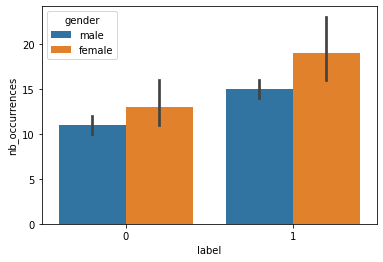

In [54]:
ax = sns.barplot(x="label", y="nb_occurrences", data=balanced_all_genders,hue="gender",estimator=np.median,n_boot=10000)

First, looking at the number of occurrences, we can see that ##continue. Explique Wilcoxon ## Do wilcoxon 

In [55]:
##Stats males
stats.wilcoxon(male_before_metoo['nb_occurrences'], male_after_metoo['nb_occurrences'])


WilcoxonResult(statistic=2314602.0, pvalue=8.9043109353326e-32)

In [56]:
effect_size = (stats.wilcoxon(male_before_metoo['nb_occurrences'], 
                              male_after_metoo['nb_occurrences'])[0])/sum(list(range(0, len(male_before_metoo))))
effect_size


0.34967257314587663

In [57]:
##Stats females
stats.wilcoxon(fmale_before_metoo['nb_occurrences'], fmale_after_metoo['nb_occurrences'])

WilcoxonResult(statistic=138984.5, pvalue=2.897238359812677e-22)

In [58]:
effect_size = (stats.wilcoxon(fmale_before_metoo['nb_occurrences'], 
                              fmale_after_metoo['nb_occurrences'])[0])/sum(list(range(0, len(fmale_before_metoo))))
effect_size

0.2879594657031035

## Transition: ce serait cool de check par category blabla let's take a first look at it blabla...

In [59]:
#converts my list into a dict, useful for generation of worldcloud : 
def Convert(lst):
    res_dct = {lst[i][0]: lst[i][0+1] for i in range(0, len(lst))}
    return res_dct

In [60]:
def create_Worldcloud(df,mask_image):
    font_path = 'data/true_south/True South.ttf'
    tupl = [tuple(x) for x in df.values]
    dict_ready = Convert(tupl)
    mask_ = np.array(Image.open(mask_image))
    df_wordcloud = wordcloud.WordCloud(font_path = font_path,width = 500,max_font_size = 300,height=500 ,background_color="white",relative_scaling = 0.4, max_words=500, mask=mask_,contour_width=3, contour_color='peru').generate_from_frequencies(dict_ready)
    return df_wordcloud

In [61]:
def get_occup (rowss,columns_occ) : 
    list_occ = columns_occ.columns.to_list()
    rowss['occupation']= []
    for i in range(0,len(list_occ)) : 
        if (rowss[list_occ[i]] == 1) :
            rowss['occupation'].append(list_occ[i])
    return (rowss)

In [62]:
balanced_all_genders= balanced_all_genders.apply(lambda row : get_occup(row,dummies_occ),axis=1)

In [63]:
df_occ_female_before = balanced_all_genders[(balanced_all_genders['label']==0)&(balanced_all_genders['gender'] == 'female')].occupation.explode(ignore_index=True)
df_occ_female_after = balanced_all_genders[(balanced_all_genders['label']==1)&(balanced_all_genders['gender'] == 'female')].occupation.explode(ignore_index=True)
df_occ_male_before = balanced_all_genders[(balanced_all_genders['label']==0)&(balanced_all_genders['gender'] == 'male')].occupation.explode(ignore_index=True)
df_occ_male_after = balanced_all_genders[(balanced_all_genders['label']==1)&(balanced_all_genders['gender'] == 'male')].occupation.explode(ignore_index=True)

In [64]:
#Compute the reprensented occupations for female speakers before me too
most_occ_female_before=pd.DataFrame(Counter(df_occ_female_before).most_common(),columns =['occupation', 'nb_occurences'])
most_occ_male_before = pd.DataFrame(Counter(df_occ_male_before).most_common(),columns =['occupation', 'nb_occurences'])
most_occ_male_before.dropna(inplace=True)
print(most_occ_female_before.head())
print(most_occ_male_before.head())

#Compute the reprensented occupations for female speakers after me too
most_occ_female_after=pd.DataFrame(Counter(df_occ_female_after).most_common(),columns =['occupation', 'nb_occurences'])
most_occ_male_after=pd.DataFrame(Counter(df_occ_male_after).most_common(),columns =['occupation', 'nb_occurences'])
most_occ_male_after.dropna(inplace=True)
print(most_occ_female_after.head())
print(most_occ_male_after.head())

                      occupation  nb_occurences
0         Teaching_and_Education            332
1                     Government            257
2                      Scientist            234
3                     Literature            193
4  Social_Sciences_and_Ethnology            141
                      occupation  nb_occurences
0         Teaching_and_Education           1439
1                     Government           1004
2                      Scientist            908
3  Social_Sciences_and_Ethnology            777
4                     Literature            677
                      occupation  nb_occurences
0         Teaching_and_Education            316
1                     Government            263
2                      Scientist            244
3                     Literature            179
4  Social_Sciences_and_Ethnology            140
                      occupation  nb_occurences
0         Teaching_and_Education           1448
1                     Government        

In [65]:
most_occ_female_before['occupation'].replace({'Teaching_and_Education':'Teaching','Social_Sciences_and_Ethnology': 'Social_sciences','Media_and_Journalism':'Media'},inplace=True)
most_occ_female_after['occupation'].replace({'Teaching_and_Education':'Teaching','Social_Sciences_and_Ethnology': 'Social_sciences','Media_and_Journalism':'Media'},inplace=True)
most_occ_male_before['occupation'].replace({'Teaching_and_Education':'Teaching','Social_Sciences_and_Ethnology': 'Social_sciences','Media_and_Journalism':'Media'},inplace=True)
most_occ_male_after['occupation'].replace({'Teaching_and_Education':'Teaching','Social_Sciences_and_Ethnology': 'Social_sciences','Media_and_Journalism':'Media'},inplace=True)

In [66]:
#before me too
Worldcloud_before_fem = create_Worldcloud(most_occ_female_before, 'data/female.png')
Worldcloud_before_mal = create_Worldcloud(most_occ_male_before,'data/male.png')

#after me too
Worldcloud_after_fem = create_Worldcloud(most_occ_female_after,'data/female.png')
Worldcloud_after_mal = create_Worldcloud(most_occ_male_after,'data/male.png')

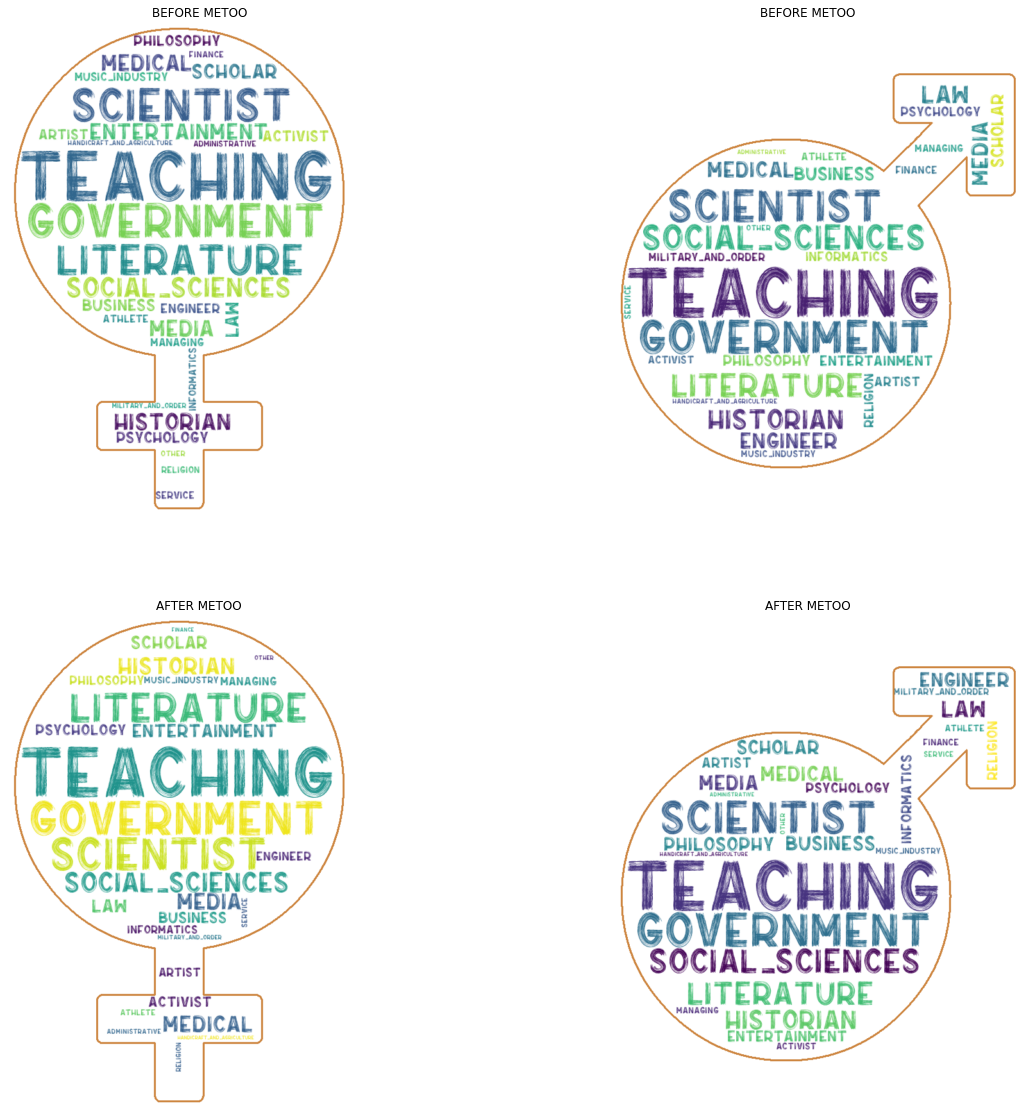

In [67]:
fig,ax = plt.subplots(2,2, figsize=(20,20))
ax[0,0].imshow(Worldcloud_before_fem, cmap=plt.cm.gray, interpolation="bilinear")
ax[0,0].axis("off")
ax[0,0].set_title('BEFORE METOO')
ax[0,1].imshow(Worldcloud_before_mal, cmap=plt.cm.gray, interpolation="bilinear")
ax[0,1].set_title('BEFORE METOO')
ax[0,1].axis("off")
ax[1,0].imshow(Worldcloud_after_fem, cmap=plt.cm.gray, interpolation="bilinear")
ax[1,0].set_title('AFTER METOO')
ax[1,0].axis("off")
ax[1,1].imshow(Worldcloud_after_mal, cmap=plt.cm.gray, interpolation="bilinear")
ax[1,1].set_title('AFTER METOO')
ax[1,1].axis("off")
plt.show()

# 4. Are some categories of occupations more represented among female speakers after #MeToo ?

Now, we will try to analyze if some categories of occupations are more represented after the movement than before among women. Here again, we will compare with the evolution of men's speech. To do that, we will focus on the 8 main represented categories in the entire dataset.

In [68]:
main_categories = data_features[dummies_occ.columns.tolist()].sum().sort_values(ascending = False).head(8)
print('The 8 categories of occupations most represented in the dataset are:', main_categories.index.to_list())

The 8 categories of occupations most represented in the dataset are: ['Teaching_and_Education', 'Government', 'Scientist', 'Social_Sciences_and_Ethnology', 'Literature', 'Historian', 'Law', 'Media_and_Journalism']


## Matching by categories

Such as in the previous section, we will match pairs of speakers according to their proprensity scores calculated above. We match exactly one speaker from the control group (speaker before #MeToo) with one speaker from the treated group (after #MeToo). We repeat the matching for each category, since we match only speakers of same gender and of same value for the category we want to analyze, i.e for example if we analyze the evolution of scientists' speech, we will pairs scientist women together, non-scientists women together, men scientists together and men non-scientists together.  

In [69]:
def match_by_category(df, category):
    # Separate the treatment and control groups
    treatment_df = df[df['label'] == 1]
    control_df = df[df['label'] == 0]

    # Create an empty undirected graph
    G = nx.Graph()

    # Loop through all the pairs of instances
    for control_id, control_row in control_df.iterrows():
        for treatment_id, treatment_row in treatment_df.iterrows():

            # Calculate the similarity 
            # Adds an edge only if the individuals have the same gender
            if (control_row['gender'] == treatment_row['gender'])  and (control_row[category] == 
                                                                        treatment_row[category]):
                similarity = get_similarity(control_row['Propensity_score'],
                                        treatment_row['Propensity_score'])

            # Add an edge between the two instances weighted by the similarity between them
                G.add_weighted_edges_from([(control_id, treatment_id, similarity)])

    # Generate and return the maximum weight matching on the generated graph
    matching = nx.max_weight_matching(G)
    
    matched = [i[0] for i in list(matching)] + [i[1] for i in list(matching)]
    
    balanced_df = df.loc[matched,:]
    balanced_df.to_json(DATA_FOLDER + f'results/balanced_{category}.json.bz2')

In [70]:
#Cellule a decommenter le jour du rendu 
"""for category in main_categories.index:
    match_by_category(speakers_once, category)""";

## Results

### Teaching and education

In [71]:
balanced_teaching = pd.concat([pd.read_json(DATA_FOLDER + 'results/balanced_Teaching_and_Education.json.bz2'), 
                               speakers_twice])

Let's look at sample sizes.

In [72]:
pd.crosstab(balanced_teaching.label, [balanced_teaching.gender, balanced_teaching.Teaching_and_Education])

gender                 female       male      
Teaching_and_Education      0    1     0     1
label                                         
0                         651  321  2200  1439
1                         651  321  2200  1439

In [73]:
gmean_occupations(balanced_teaching, 'Teaching_and_Education', 'nb_quotes')

GEOMETRIC MEANS
Male speakers
                              Before #MeToo    After #MeToo
--------------------------  ---------------  --------------
Non Teaching_and_Education          8.92368         12.9206
Teaching_and_Education              7.25589         10.0746


Female speakers
                              Before #MeToo    After #MeToo
--------------------------  ---------------  --------------
Non Teaching_and_Education         10.248           17.4888
Teaching_and_Education              7.94348         10.9829


### Government

In [74]:
balanced_government = pd.concat([pd.read_json(DATA_FOLDER + 'results/balanced_Government.json.bz2'), 
                               speakers_twice])

Let's take a look at sample sizes.

In [75]:
pd.crosstab(balanced_government.label, [balanced_government.gender, balanced_government.Government])

gender     female       male      
Government      0    1     0     1
label                             
0             726  257  2635  1004
1             726  257  2635  1004

Note: the distributions are skewed. Thus we represent them on a log-log scale.

In [76]:
gmean_occupations(balanced_government, 'Government', 'nb_quotes')

GEOMETRIC MEANS
Male speakers
                  Before #MeToo    After #MeToo
--------------  ---------------  --------------
Non Government           7.0203         9.91399
Government              12.451         18.0582


Female speakers
                  Before #MeToo    After #MeToo
--------------  ---------------  --------------
Non Government          7.89492         11.7085
Government             14.7783          28.1394


In [77]:
##TODO peut être: trouver un test statistique qui peut comparer des skewed distributions? 

### Scientist

In [78]:
balanced_scientist = pd.concat([pd.read_json(DATA_FOLDER + 'results/balanced_Scientist.json.bz2'), 
                               speakers_twice])

In [79]:
pd.crosstab(balanced_scientist.label, [balanced_scientist.gender, balanced_scientist.Scientist])

gender    female       male     
Scientist      0    1     0    1
label                           
0            749  234  2731  908
1            749  234  2731  908

In [80]:
gmean_occupations(balanced_scientist, 'Scientist', 'nb_quotes')

GEOMETRIC MEANS
Male speakers
                 Before #MeToo    After #MeToo
-------------  ---------------  --------------
Non Scientist          8.6995         12.5071
Scientist              6.94032         9.72743


Female speakers
                 Before #MeToo    After #MeToo
-------------  ---------------  --------------
Non Scientist          9.19824         15.4025
Scientist              9.63801         13.0352


### Social Science

In [81]:
balanced_social_sciences = pd.concat([pd.read_json(DATA_FOLDER + 'results/balanced_Social_Sciences_and_Ethnology.json.bz2'), 
                               speakers_twice])

In [82]:
pd.crosstab(balanced_social_sciences.label, [balanced_social_sciences.gender, balanced_social_sciences.Social_Sciences_and_Ethnology])

gender                        female       male     
Social_Sciences_and_Ethnology      0    1     0    1
label                                               
0                                842  141  2862  777
1                                842  141  2862  777

In [83]:
gmean_occupations(balanced_social_sciences, 'Social_Sciences_and_Ethnology', 'nb_quotes')

GEOMETRIC MEANS
Male speakers
                                     Before #MeToo    After #MeToo
---------------------------------  ---------------  --------------
Non Social_Sciences_and_Ethnology          7.98855         11.4062
Social_Sciences_and_Ethnology              9.14576         12.9346


Female speakers
                                     Before #MeToo    After #MeToo
---------------------------------  ---------------  --------------
Non Social_Sciences_and_Ethnology          9.29252         14.5194
Social_Sciences_and_Ethnology              9.35228         16.4839


### Literature

In [84]:
balanced_literature = pd.concat([pd.read_json(DATA_FOLDER + 'results/balanced_Literature.json.bz2'), 
                               speakers_twice])

In [85]:
pd.crosstab(balanced_literature.label, [balanced_literature.gender, balanced_literature.Literature])

gender     female       male     
Literature      0    1     0    1
label                            
0             790  182  2962  677
1             790  182  2962  677

In [86]:
gmean_occupations(balanced_literature, 'Literature', 'nb_quotes')

GEOMETRIC MEANS
Male speakers
                  Before #MeToo    After #MeToo
--------------  ---------------  --------------
Non Literature          7.74436         11.1171
Literature             10.6877          14.981


Female speakers
                  Before #MeToo    After #MeToo
--------------  ---------------  --------------
Non Literature          8.99767         14.1992
Literature             11.6524          18.8022


### Historian

In [87]:
balanced_historian = pd.concat([pd.read_json(DATA_FOLDER + 'results/balanced_Historian.json.bz2'), 
                               speakers_twice])

In [88]:
pd.crosstab(balanced_historian.label, [balanced_historian.gender, balanced_historian.Historian])

gender    female      male     
Historian      0   1     0    1
label                          
0            897  86  3238  401
1            897  86  3238  401

In [89]:
gmean_occupations(balanced_historian, 'Historian', 'nb_quotes')

GEOMETRIC MEANS
Male speakers
                 Before #MeToo    After #MeToo
-------------  ---------------  --------------
Non Historian          8.55173        12.1655
Historian              5.98975         8.74262


Female speakers
                 Before #MeToo    After #MeToo
-------------  ---------------  --------------
Non Historian          9.94939        15.9062
Historian              4.60582         7.49377


### Law

In [90]:
balanced_law = pd.concat([pd.read_json(DATA_FOLDER + 'results/balanced_Law.json.bz2'), 
                               speakers_twice])

In [91]:
pd.crosstab(balanced_law.label, [balanced_law.gender, balanced_law.Law])

gender female      male     
Law         0   1     0    1
label                       
0         920  63  3338  301
1         920  63  3338  301

In [92]:
gmean_occupations(balanced_law, 'Law', 'nb_quotes')

GEOMETRIC MEANS
Male speakers
           Before #MeToo    After #MeToo
-------  ---------------  --------------
Non Law          7.85242         11.2654
Law             13.7059          18.7161


Female speakers
           Before #MeToo    After #MeToo
-------  ---------------  --------------
Non Law          8.74906         13.6683
Law             22.7279          44.323


### Media

In [93]:
balanced_media = pd.concat([pd.read_json(DATA_FOLDER + 'results/balanced_Media_and_Journalism.json.bz2'), 
                               speakers_twice])

In [94]:
pd.crosstab(balanced_media.label, [balanced_media.gender, balanced_media.Media_and_Journalism])

gender               female      male     
Media_and_Journalism      0   1     0    1
label                                     
0                       904  79  3415  214
1                       904  79  3415  214

In [95]:
gmean_occupations(balanced_media, 'Media_and_Journalism', 'nb_quotes')

GEOMETRIC MEANS
Male speakers
                            Before #MeToo    After #MeToo
------------------------  ---------------  --------------
Non Media_and_Journalism          8.14683         11.6479
Media_and_Journalism             10.1825          13.8373


Female speakers
                            Before #MeToo    After #MeToo
------------------------  ---------------  --------------
Non Media_and_Journalism          9.2458          14.7306
Media_and_Journalism              9.95757         14.7079


## Code plus concis?

In [96]:
cat=[balanced_teaching, balanced_government, balanced_scientist, balanced_social_sciences,balanced_literature,
    balanced_historian, balanced_law, balanced_media]

cat_names=["Teaching_and_Education", "Government", "Scientist", "Social_Sciences_and_Ethnology","Literature",
    "Historian", "Law", "Media_and_Journalism"]

cat_non_names=["Non_Teaching_and_Education", "Non_Government", "Non_Scientist", "Non_Social_Sciences_and_Ethnology","Non_Literature",
    "Non_Historian", "Non_Law", "Non_Media_and_Journalism"]


In [97]:
def tablegmeans(c,name):
    print("\033[1m" + name + "\033[0m")
    print(pd.crosstab(c.label, [c.gender, c[name]]))
    gmean_occupations(c, name, 'nb_quotes')

In [98]:
k=0
for c in cat:
    tablegmeans(c,cat_names[k])
    print("a\b")
    k+=1

Teaching_and_Education
gender                 female       male      
Teaching_and_Education      0    1     0     1
label                                         
0                         651  321  2200  1439
1                         651  321  2200  1439
GEOMETRIC MEANS
Male speakers
                              Before #MeToo    After #MeToo
--------------------------  ---------------  --------------
Non Teaching_and_Education          8.92368         12.9206
Teaching_and_Education              7.25589         10.0746


Female speakers
                              Before #MeToo    After #MeToo
--------------------------  ---------------  --------------
Non Teaching_and_Education         10.248           17.4888
Teaching_and_Education              7.94348         10.9829

Government
gender     female       male      
Government      0    1     0     1
label                             
0             726  257  2635  1004
1             726  257  2635  1004
GEOMETRIC MEANS
Male speake

### Comparison of categories ####

In [99]:
#Function to build a dataFrame for a specific balanced_occupation, classify speakers between occupation and non_occupation
def create_dF_category(c,name,non_name):
    yes=c[(c[name] == 1)][['nb_quotes','nb_occurrences','label','gender',name]]
    dfYes=pd.DataFrame(yes)
    dfYes['Occupation'] = name
    no=c[(c[name] == 0)][['nb_quotes','nb_occurrences','label','gender',name]]
    dfNo=pd.DataFrame(no)
    dfNo['Occupation'] = non_name
    Full=pd.concat([dfYes,dfNo])
    return Full    

In [100]:
#Creation of one dataFrame for each occupation
fulls=[]
j=0
for n in range(8):
    d=create_dF_category(cat[j],cat_names[j],cat_non_names[j])
    fulls.append(d)
    j+=1

In [101]:
#Function to build a dataFrame for each balanced_occupation with only the speakers who performed this occupation
def create_dF_yes(c,name,non_name):
    yes=c[(c[name] == 1)][['nb_quotes','nb_occurrences','label','gender',name]]
    dfYes=pd.DataFrame(yes)
    dfYes['Occupation'] = name
    return dfYes


In [102]:
#Creation of one dataframe per occupation with only the positive occupation concatenation of all the dataframes
yey=[]
j=0
for n in range(8):
    e=create_dF_yes(cat[j],cat_names[j],cat_non_names[j])
    e.drop([cat_names[j]], axis = 1, inplace = True)
    yey.append(e)
    j+=1
ye=pd.concat(yey)


In [103]:
ye.replace({"Teaching_and_Education": "Teaching",
             "Social_Sciences_and_Ethnology":"Social_Sciences",
            "Media_and_Journalism":"Media"},inplace=True)

#### Gmean nb_quotations female/male for all categories

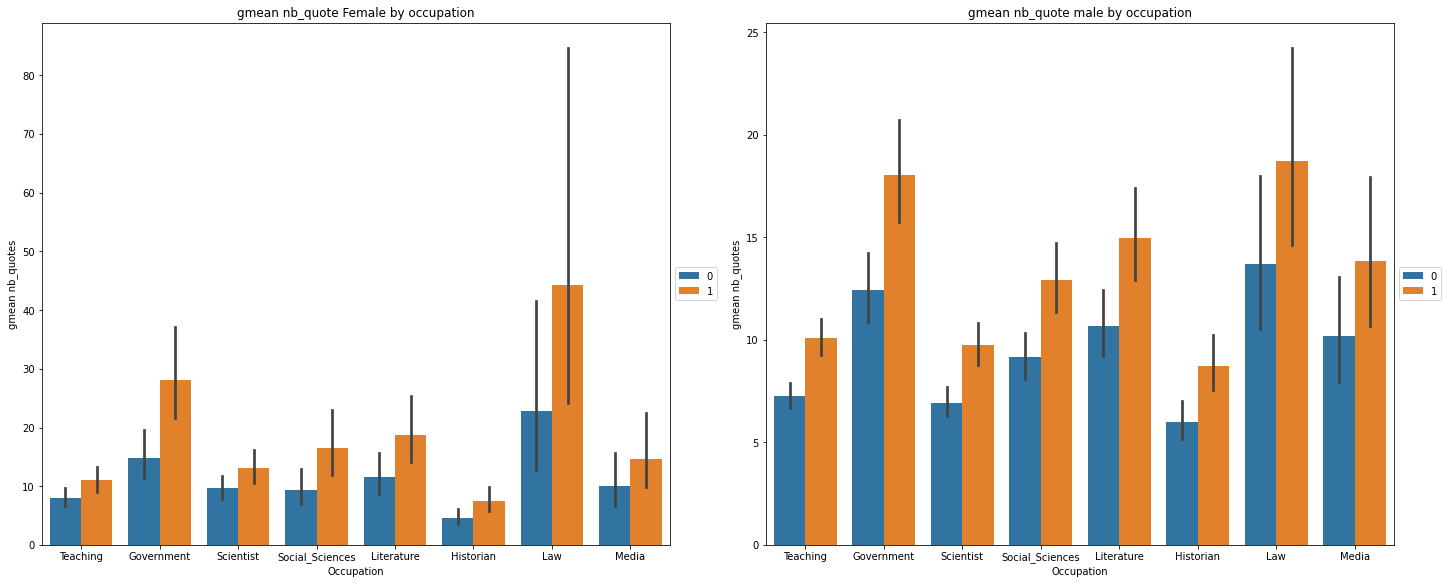

In [104]:
fig, ax = plt.subplots(nrows=1, ncols=2, constrained_layout=True, figsize=(20, 8)) 
sns.barplot(ax=ax[0],x = 'Occupation', y = 'nb_quotes', hue = 'label', 
                data = ye[(ye['gender'] == "female")], estimator=stats.mstats.gmean,n_boot=10000);
ax[0].set(ylabel='gmean nb_quotes')
ax[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax[0].set_title('gmean nb_quote Female by occupation');


sns.barplot(ax=ax[1],x = 'Occupation', y = 'nb_quotes', hue = 'label', 
                data = ye[(ye['gender'] == "male")], estimator=stats.mstats.gmean,n_boot=10000);
ax[1].set(ylabel='gmean nb_quotes')
ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax[1].set_title('gmean nb_quote male by occupation');


#### Gmean nb_occurences female/male for all categories

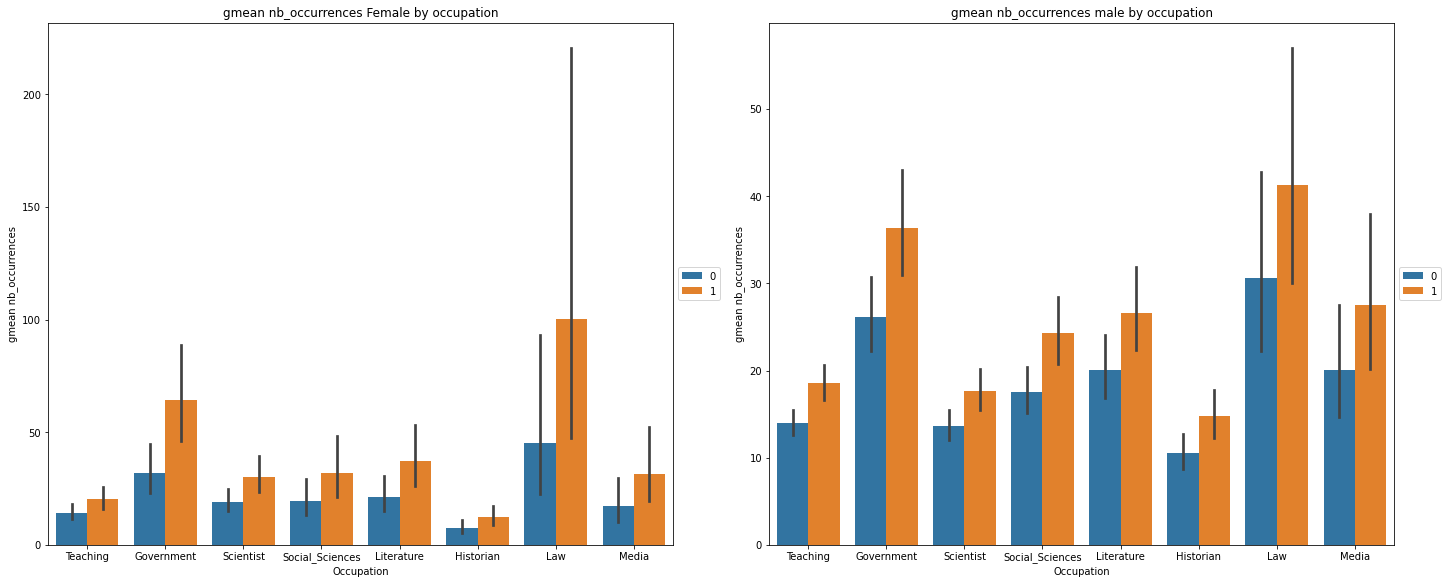

In [105]:
fig, ax = plt.subplots(nrows=1, ncols=2, constrained_layout=True, figsize=(20, 8)) 
sns.barplot(ax=ax[0],x = 'Occupation', y = 'nb_occurrences', hue = 'label', 
                data = ye[(ye['gender'] == "female")], estimator=stats.mstats.gmean,n_boot=10000);
ax[0].set(ylabel='gmean nb_occurrences')
ax[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax[0].set_title('gmean nb_occurrences Female by occupation');


sns.barplot(ax=ax[1],x = 'Occupation', y = 'nb_occurrences', hue = 'label', 
                data = ye[(ye['gender'] == "male")], estimator=stats.mstats.gmean,n_boot=10000);
ax[1].set(ylabel='gmean nb_occurrences')
ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax[1].set_title('gmean nb_occurrences male by occupation');


#### Median nb_quotations female/male for all categories

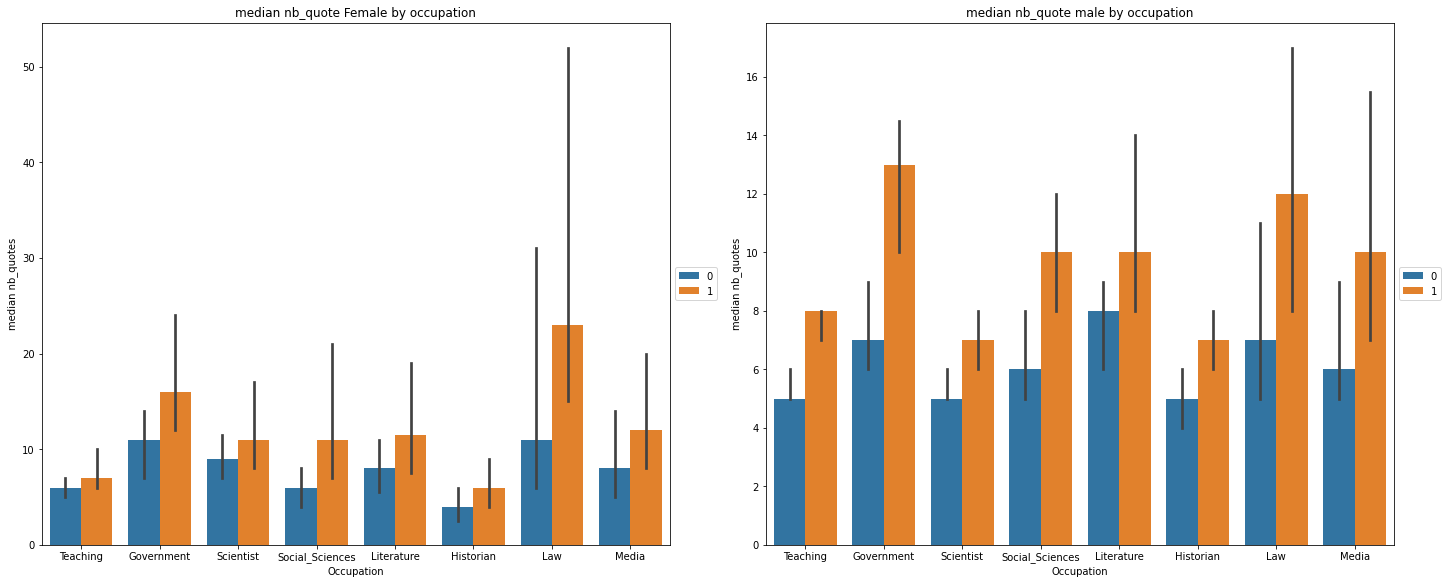

In [106]:
fig, ax = plt.subplots(nrows=1, ncols=2, constrained_layout=True, figsize=(20, 8)) 
sns.barplot(ax=ax[0],x = 'Occupation', y = 'nb_quotes', hue = 'label', 
                data = ye[(ye['gender'] == "female")], estimator=np.median,n_boot=10000);

ax[0].set(ylabel='median nb_quotes')
ax[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax[0].set_title('median nb_quote Female by occupation');

sns.barplot(ax=ax[1],x = 'Occupation', y = 'nb_quotes', hue = 'label', 
                data = ye[(ye['gender'] == "male")], estimator=np.median,n_boot=10000);
ax[1].set(ylabel='median nb_quotes')
ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax[1].set_title('median nb_quote male by occupation');

#### Median nb_occurences female/male for all categories

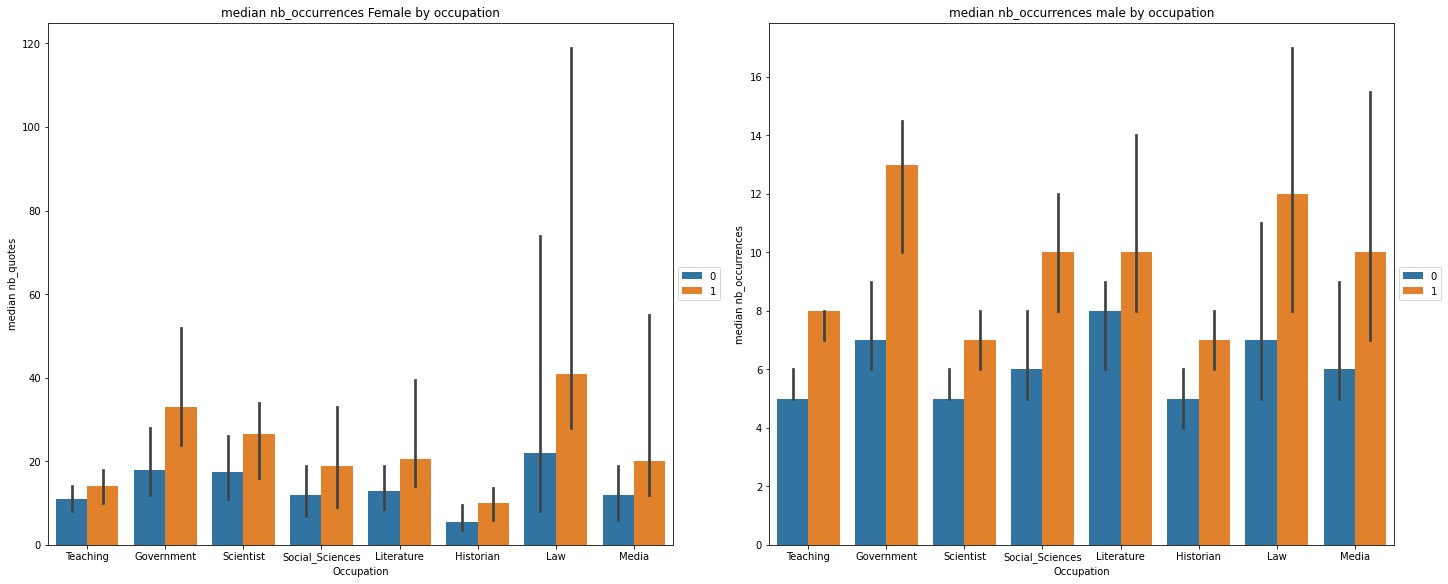

In [107]:
fig, ax = plt.subplots(nrows=1, ncols=2, constrained_layout=True, figsize=(20, 8)) 
sns.barplot(ax=ax[0],x = 'Occupation', y = 'nb_occurrences', hue = 'label', 
                data = ye[(ye['gender'] == "female")], estimator=np.median,n_boot=10000);

ax[0].set(ylabel='median nb_quotes')
ax[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax[0].set_title('median nb_occurrences Female by occupation');

sns.barplot(ax=ax[1],x = 'Occupation', y = 'nb_quotes', hue = 'label', 
                data = ye[(ye['gender'] == "male")], estimator=np.median,n_boot=10000);
ax[1].set(ylabel='median nb_occurrences')
ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax[1].set_title('median nb_occurrences male by occupation');

### Gmean nb_quotations par occupation et par genre

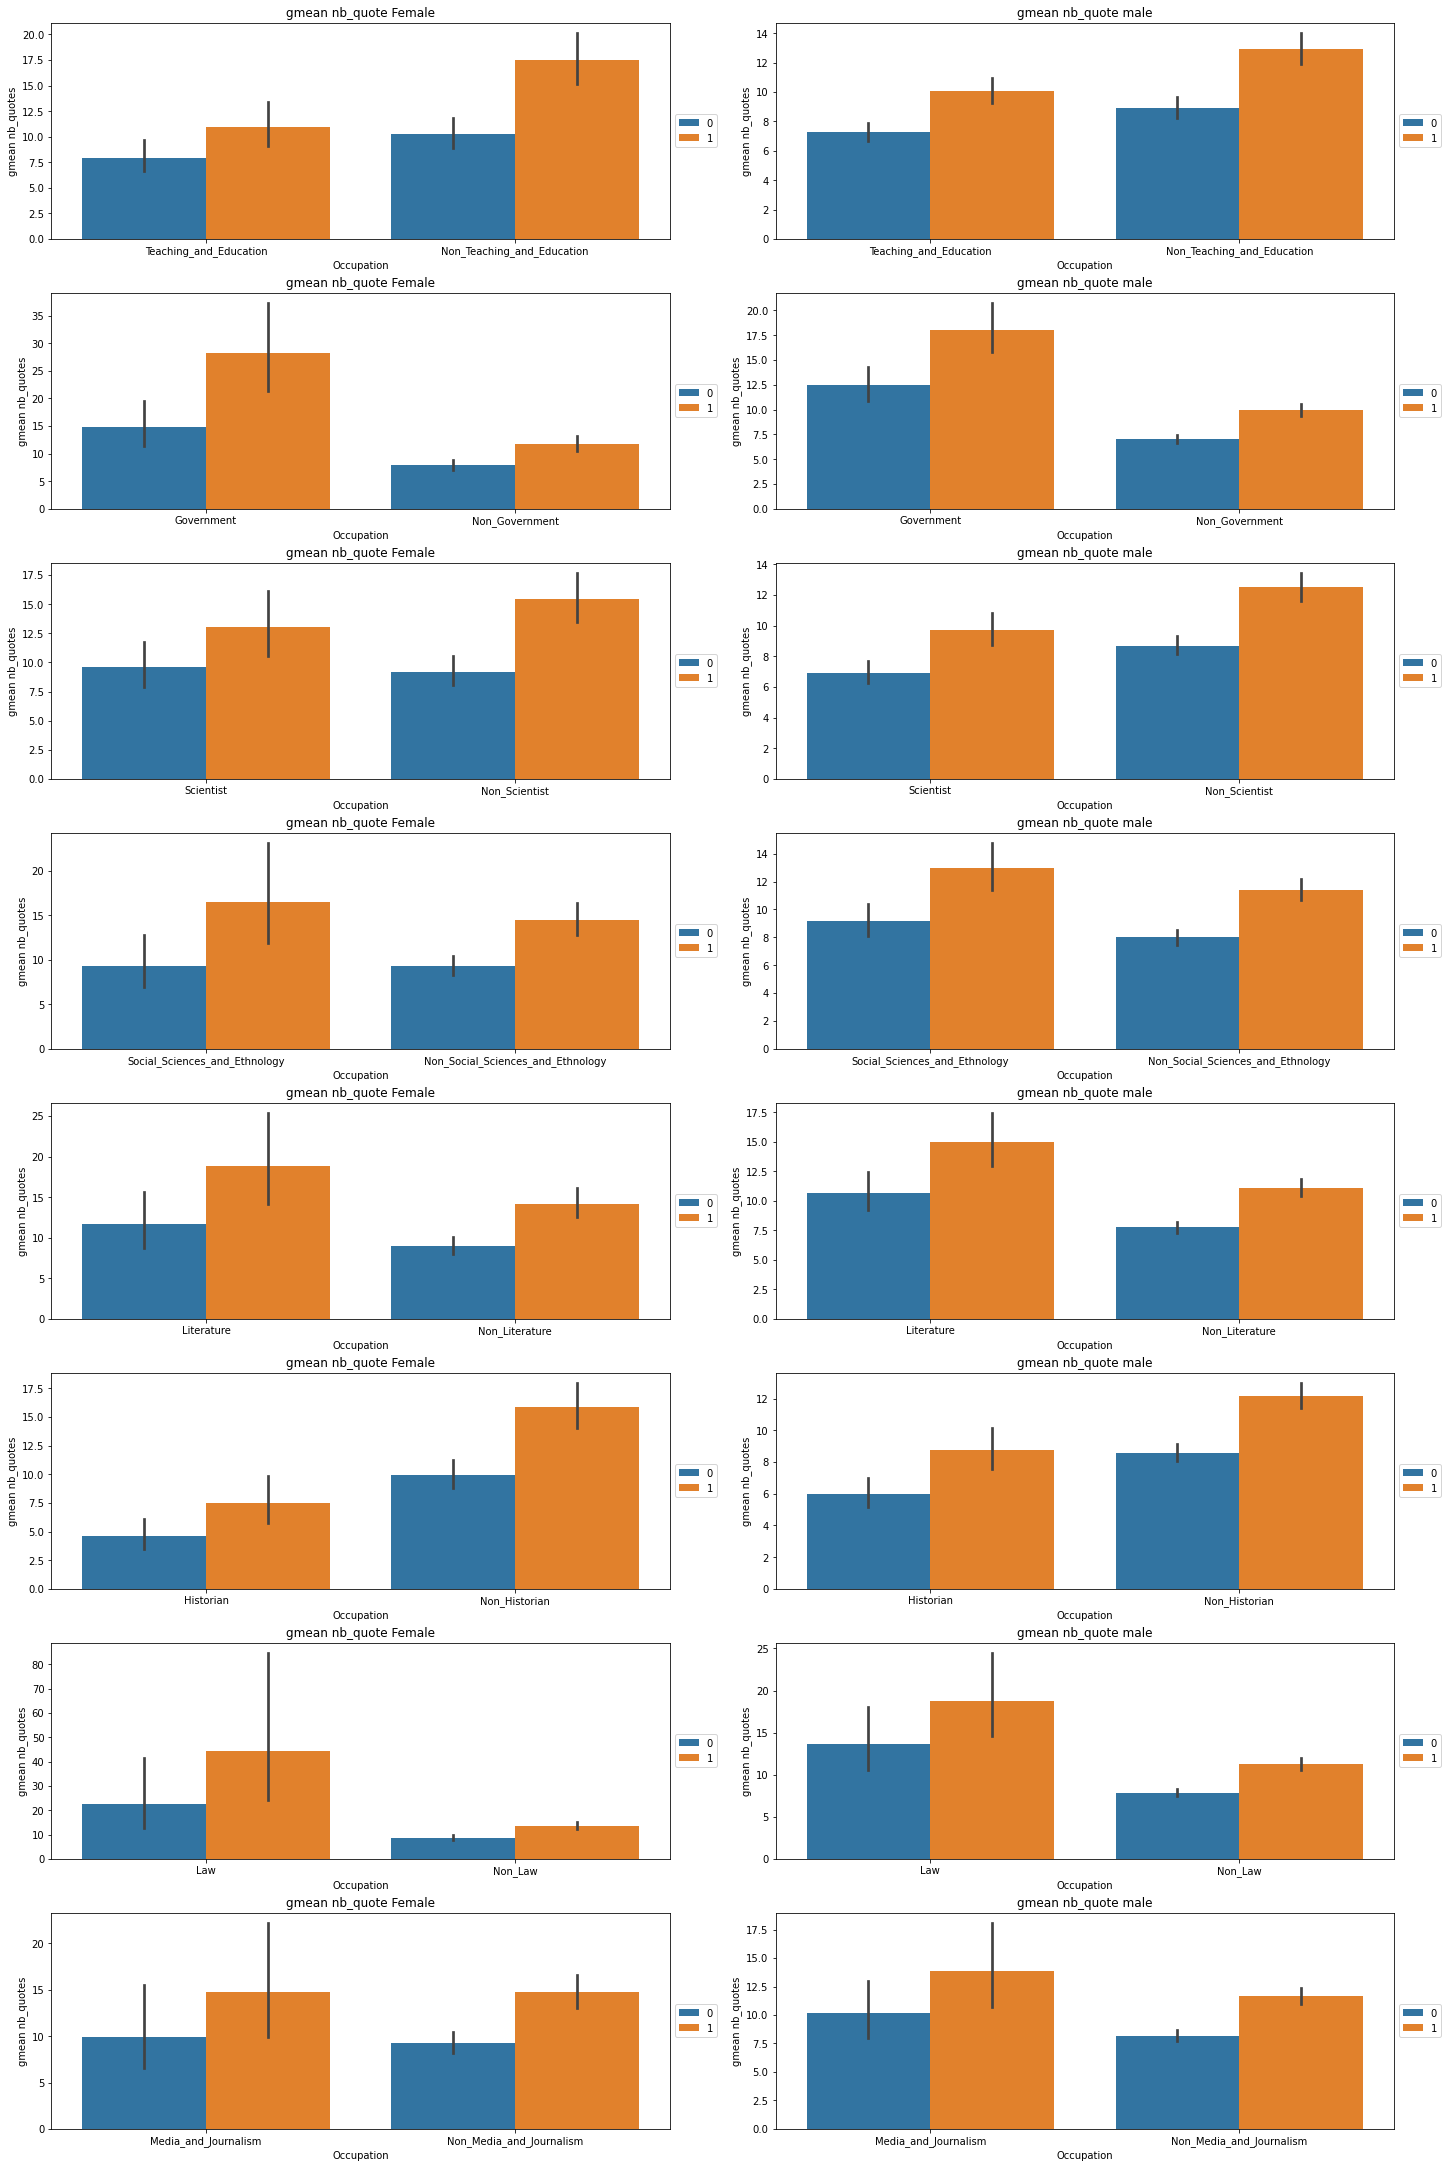

In [108]:
fig, ax = plt.subplots(nrows=8, ncols=2, constrained_layout=True, figsize=(20, 30));
i=0
for f in fulls:
    sns.barplot(ax=ax[i,0], x = 'Occupation', y = 'nb_quotes', hue = 'label', 
                data = f[(f['gender'] == "female")], estimator=stats.mstats.gmean,n_boot=10000);
    sns.barplot(ax=ax[i,1], x = 'Occupation', y = 'nb_quotes', hue = 'label', 
                data = f[(f['gender'] == "male")], estimator=stats.mstats.gmean,n_boot=10000);
    ax[i,0].set(ylabel='gmean nb_quotes');
    ax[i,0].legend(loc='center left', bbox_to_anchor=(1, 0.5));
    ax[i,0].set_title('gmean nb_quote Female');
    ax[i,1].set(ylabel='gmean nb_quotes');
    ax[i,1].legend(loc='center left', bbox_to_anchor=(1, 0.5));
    ax[i,1].set_title('gmean nb_quote male');

    i+=1

### median nb_quotations par occupation et par genre

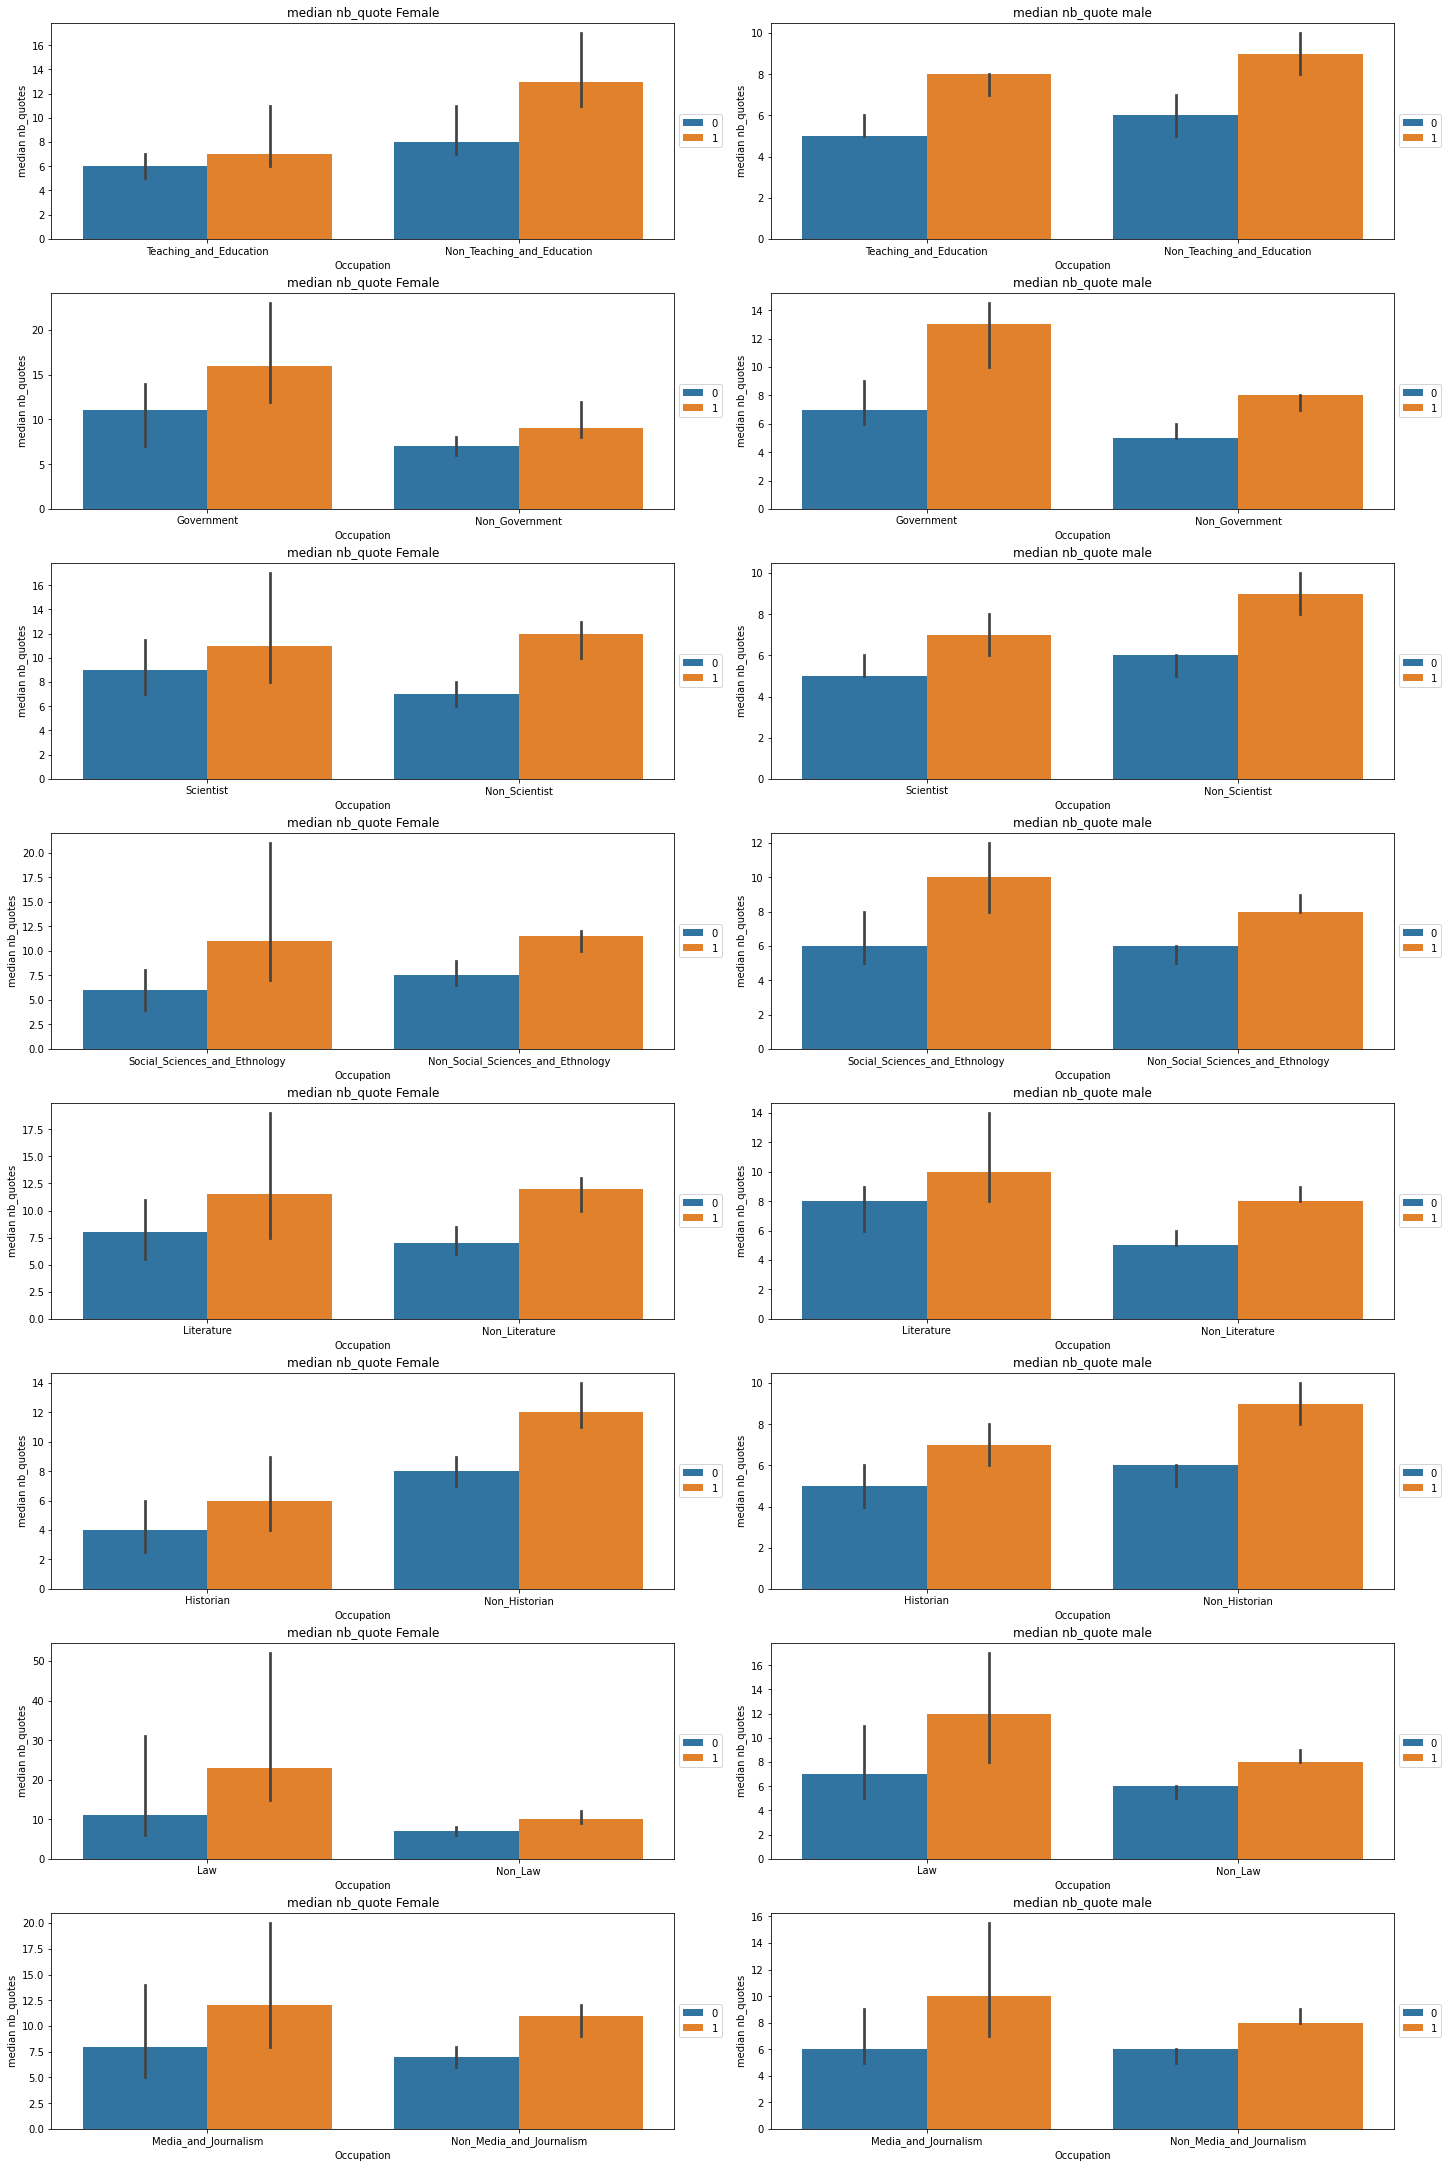

In [109]:
fig, ax = plt.subplots(nrows=8, ncols=2, constrained_layout=True, figsize=(20, 30));
i=0
for f in fulls:
    sns.barplot(ax=ax[i,0], x = 'Occupation', y = 'nb_quotes', hue = 'label', 
                data = f[(f['gender'] == "female")], estimator=np.median,n_boot=10000);
    sns.barplot(ax=ax[i,1], x = 'Occupation', y = 'nb_quotes', hue = 'label', 
                data = f[(f['gender'] == "male")], estimator=np.median,n_boot=10000);
    ax[i,0].set(ylabel='median nb_quotes');
    ax[i,0].legend(loc='center left', bbox_to_anchor=(1, 0.5));
    ax[i,0].set_title('median nb_quote Female');
    ax[i,1].set(ylabel='median nb_quotes');
    ax[i,1].legend(loc='center left', bbox_to_anchor=(1, 0.5));
    ax[i,1].set_title('median nb_quote male');

    i+=1
